<a href="https://colab.research.google.com/github/neverstones/geo_inquire_project/blob/main/Copia_di_Localizzazione_ipocentri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
!pip install geopy
!pip install pandas
!pip install pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.7 MB/s eta 0:00:00


In [ ]:
print("DEM lat min-max:", lat_vals.min(), "-", lat_vals.max())
print("DEM lon min-max:", lon_vals.min(), "-", lon_vals.max())
print("Profilo lat min-max:", lat_points.min(), "-", lat_points.max())
print("Profilo lon min-max:", lon_points.min(), "-", lon_points.max())

DEM lat min-max: 4171108.0 - 4186064.0
DEM lon min-max: 495244.0 - 510364.0
Profilo lat min-max: 37.692157 - 37.774135
Profilo lon min-max: 14.993286 - 15.014189


In [ ]:
wgs84 = pyproj.CRS("EPSG:4326")

# Trova il sistema UTM corretto per l'Etna (probabilmente UTM zona 33N, ESPG:32633)
utm = pyproj.CRS("EPSG:32633")

# Crea un convertitore di coordinate
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

# Converti la sezione in coordinate UTM
utm_x_points, utm_y_points = transformer.transform(lon_points, lat_points)

# Ora possiamo interpolare le altezze correttamente
heights = interp_dem(np.array([utm_y_points, utm_x_points]).T)

In [ ]:
# Interpola le altezze lungo la sezione

# ---- 4. Carica i dati dei terremoti ----
earthquake_data = pd.read_csv(quake_path, sep=';')

   #EventID                        Time  Latitude  Longitude  Depth/Km  \
0  37325701  2024-01-13T01:32:42.230000    37.728     14.955       7.1   
1  37364031  2024-01-17T23:10:34.320000    37.748     14.942      11.7   
2  37409381  2024-01-23T20:17:58.730000    37.745     15.037       4.0   
3  37443131  2024-01-28T11:03:01.880000    37.726     14.962       5.7   
4  37596541  2024-02-14T21:01:09.570000    37.742     14.974       6.8   

                             Author MagType  Magnitude  \
0  SURVEY-INGV-CT#SeismPicker_SO-OE      ML        1.4   
1  SURVEY-INGV-CT#SeismPicker_SO-OE      ML        1.1   
2  SURVEY-INGV-CT#SeismPicker_SO-OE      ML        1.3   
3  SURVEY-INGV-CT#SeismPicker_SO-OE      ML        1.4   
4  SURVEY-INGV-CT#SeismPicker_SO-OE      ML        1.3   

              EventLocationName  
0          11 km N Ragalna (CT)  
1           11 km E Bronte (CT)  
2              7 km W Milo (CT)  
3          11 km N Ragalna (CT)  
4  13 km W Zafferana Etnea (CT)  


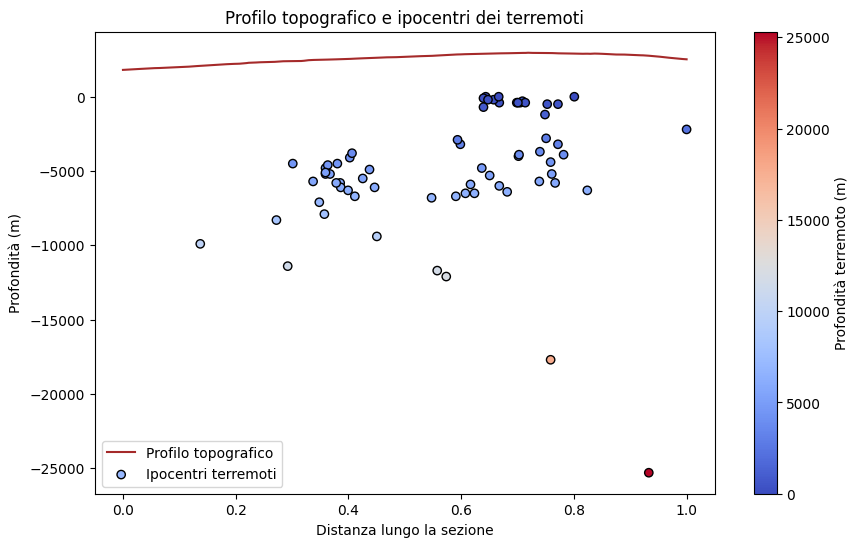

In [ ]:
import numpy as np
import rasterio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import pyproj
from geopy.distance import geodesic
import pandas as pd

# ---- 1. Carica il DEM ----
dem_path = "/content/drive/MyDrive/dati/dem_2015_4m.tiff"  # Sostituisci con il tuo percorso DEM

with rasterio.open(dem_path) as dem:
    elevation = dem.read(1)  # Legge il primo canale (altitudine)
    transform = dem.transform  # Matrice di trasformazione
    bounds = dem.bounds  # Limiti del DEM
    x_size, y_size = dem.width, dem.height  # Dimensioni del DEM
    x_range = np.linspace(bounds.left, bounds.right, x_size)  # Longitudini
    y_range = np.linspace(bounds.top, bounds.bottom, y_size)  # Latitudini
    interp_dem = RegularGridInterpolator((y_range[::-1], x_range), elevation)

# ---- 2. Definisci la sezione topografica ----
start_lat, start_lon = 37.692157, 14.993286
end_lat, end_lon = 37.774135, 15.014189
num_points = 1000

lat_points = np.linspace(start_lat, end_lat, num_points)
lon_points = np.linspace(start_lon, end_lon, num_points)

# ---- 3. Conversione delle coordinate in UTM ----
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:32633")  # UTM zona 33N, adatto all'Etna

# Crea un convertitore di coordinate
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

# Converti la sezione in coordinate UTM
utm_x_points, utm_y_points = transformer.transform(lon_points, lat_points)

# ---- 4. Interpolazione delle altezze lungo il profilo ----
heights = interp_dem(np.array([utm_y_points, utm_x_points]).T)

# ---- 5. Carica i dati dei terremoti ----
quake_path = "/content/drive/MyDrive/dati/terremoti2.csv"  # Sostituisci con il tuo file CSV
earthquake_data = pd.read_csv(quake_path, sep=';')
print(earthquake_data.head())

# Correggi le coordinate degli ipocentri
quake_lat = earthquake_data["Latitude"].values
quake_lon = earthquake_data["Longitude"].values
quake_depth = earthquake_data["Depth/Km"].values * 1000  # Converti in metri

# Converti gli ipocentri in UTM
quake_x_utm, quake_y_utm = transformer.transform(quake_lon, quake_lat)

# ---- 6. Proietta gli ipocentri sulla sezione ----
def project_onto_section(x, y, x_line, y_line):
    """ Trova il punto della sezione più vicino a un ipocentro e restituisce la distanza normalizzata. """
    distances = np.sqrt((x - x_line)**2 + (y - y_line)**2)
    return np.argmin(distances) / (len(x_line) - 1)

quake_distances = np.array([
    project_onto_section(x, y, utm_x_points, utm_y_points)
    for x, y in zip(quake_x_utm, quake_y_utm)
])

# ---- 7. Plotta il profilo e gli ipocentri ----
fig, ax = plt.subplots(figsize=(10, 6))

# Profilo topografico
ax.plot(np.linspace(0, 1, num_points), heights, color="brown", label="Profilo topografico")

# Ipocentri dei terremoti
sc = ax.scatter(quake_distances, -quake_depth, c=quake_depth,
                cmap="coolwarm", edgecolors="black", label="Ipocentri terremoti")

# Etichette e legenda
ax.set_xlabel("Distanza lungo la sezione")
ax.set_ylabel("Profondità (m)")
ax.set_title("Profilo topografico e ipocentri dei terremoti")
ax.legend()
cbar = plt.colorbar(sc)
cbar.set_label("Profondità terremoto (m)")

plt.show()

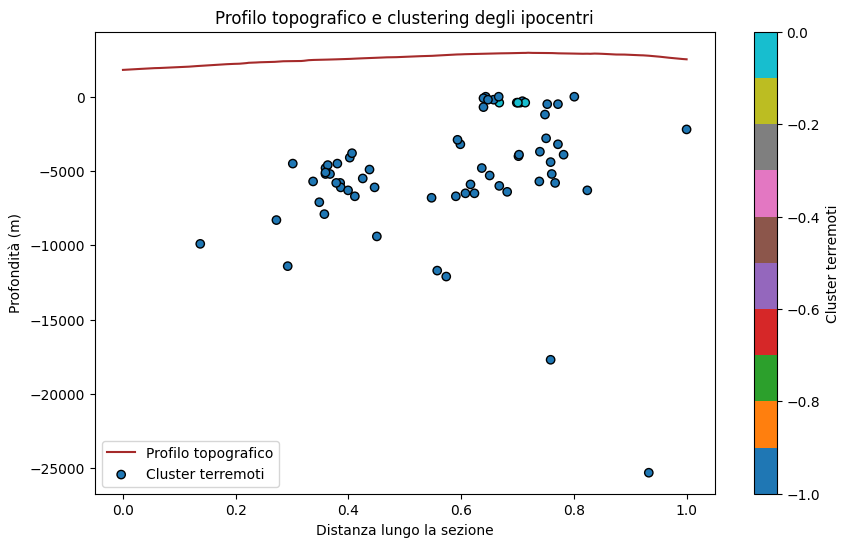

In [ ]:
import numpy as np
import rasterio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import pyproj
import pandas as pd
from sklearn.cluster import DBSCAN

# ---- 1. Carica il DEM ----
dem_path = "/content/drive/MyDrive/dati/dem_2015_4m.tiff"

with rasterio.open(dem_path) as dem:
    elevation = dem.read(1)
    transform = dem.transform
    bounds = dem.bounds
    x_size, y_size = dem.width, dem.height
    x_range = np.linspace(bounds.left, bounds.right, x_size)
    y_range = np.linspace(bounds.top, bounds.bottom, y_size)
    interp_dem = RegularGridInterpolator((y_range[::-1], x_range), elevation)

# ---- 2. Definisci la sezione topografica ----
start_lat, start_lon = 37.692157, 14.993286
end_lat, end_lon = 37.774135, 15.014189
num_points = 1000

lat_points = np.linspace(start_lat, end_lat, num_points)
lon_points = np.linspace(start_lon, end_lon, num_points)

# ---- 3. Conversione delle coordinate in UTM ----
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:32633")

transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)
utm_x_points, utm_y_points = transformer.transform(lon_points, lat_points)

# ---- 4. Interpolazione delle altezze lungo il profilo ----
heights = interp_dem(np.array([utm_y_points, utm_x_points]).T)

# ---- 5. Carica i dati dei terremoti ----
quake_path = "/content/drive/MyDrive/dati/terremoti2.csv"
earthquake_data = pd.read_csv(quake_path, sep=';')

quake_lat = earthquake_data["Latitude"].values
quake_lon = earthquake_data["Longitude"].values
quake_depth = earthquake_data["Depth/Km"].values * 1000

# Converti gli ipocentri in UTM
quake_x_utm, quake_y_utm = transformer.transform(quake_lon, quake_lat)

# ---- 6. Proietta gli ipocentri sulla sezione ----
def project_onto_section(x, y, x_line, y_line):
    distances = np.sqrt((x - x_line)**2 + (y - y_line)**2)
    return np.argmin(distances) / (len(x_line) - 1)

quake_distances = np.array([
    project_onto_section(x, y, utm_x_points, utm_y_points)
    for x, y in zip(quake_x_utm, quake_y_utm)
])

# ---- 7. Clustering con DBSCAN ----
quake_data = np.column_stack((quake_distances, quake_depth))
dbscan = DBSCAN(eps=0.05, min_samples=5)  # eps controlla la distanza massima tra punti per formarne un cluster
labels = dbscan.fit_predict(quake_data)

# ---- 8. Plotta il profilo e gli ipocentri con clustering ----
fig, ax = plt.subplots(figsize=(10, 6))

# Profilo topografico
ax.plot(np.linspace(0, 1, num_points), heights, color="brown", label="Profilo topografico")

# Ipocentri dei terremoti con clustering
sc = ax.scatter(quake_distances, -quake_depth, c=labels, cmap="tab10", edgecolors="black", label="Cluster terremoti")

# Etichette e legenda
ax.set_xlabel("Distanza lungo la sezione")
ax.set_ylabel("Profondità (m)")
ax.set_title("Profilo topografico e clustering degli ipocentri")
ax.legend()
cbar = plt.colorbar(sc)
cbar.set_label("Cluster terremoti")

plt.show()


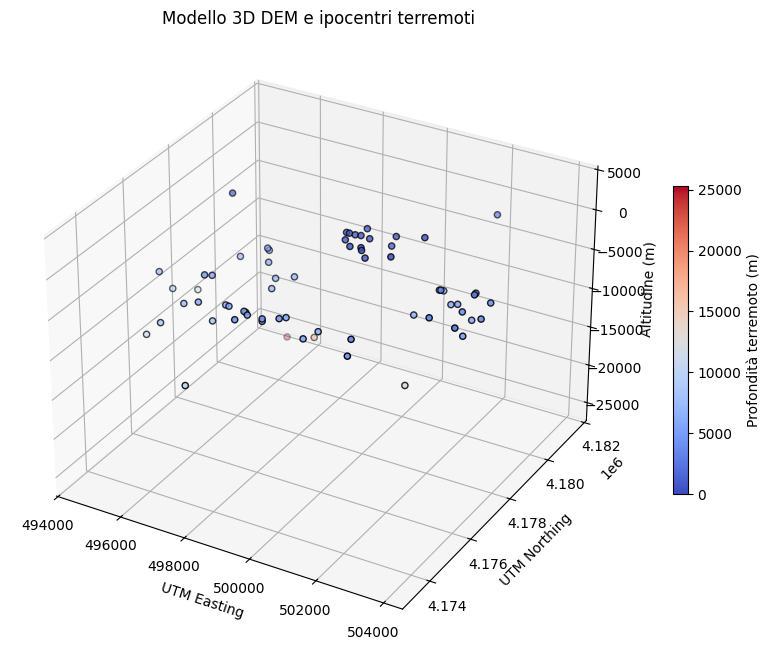

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pyproj
import pandas as pd

# ---- 1. Carica il DEM ----
dem_path = "/content/drive/MyDrive/dati/dem_2015_4m.tiff"  # Sostituisci con il tuo percorso DEM

with rasterio.open(dem_path) as dem:
    elevation = dem.read(1)  # Legge il primo canale (altitudine)
    transform = dem.transform  # Matrice di trasformazione
    bounds = dem.bounds  # Limiti del DEM
    x_size, y_size = dem.width, dem.height  # Dimensioni del DEM
    x_range = np.linspace(bounds.left, bounds.right, x_size)  # Longitudini
    y_range = np.linspace(bounds.top, bounds.bottom, y_size)  # Latitudini
    X, Y = np.meshgrid(x_range, y_range[::-1])  # Crea la griglia di coordinate

# ---- 2. Carica i dati dei terremoti ----
quake_path = "/content/drive/MyDrive/dati/terremoti2.csv"  # Sostituisci con il tuo file CSV
earthquake_data = pd.read_csv(quake_path, sep=';')

# Correggi le coordinate degli ipocentri
quake_lat = earthquake_data["Latitude"].values
quake_lon = earthquake_data["Longitude"].values
quake_depth = earthquake_data["Depth/Km"].values * 1000  # Converti in metri

# ---- 3. Converti coordinate geografiche in UTM ----
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:32633")  # UTM zona 33N per l'Etna
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

# Converti DEM e terremoti in coordinate UTM
X_utm, Y_utm = transformer.transform(X.flatten(), Y.flatten())
quake_x_utm, quake_y_utm = transformer.transform(quake_lon, quake_lat)

# Riformatta X e Y per la superficie DEM
X_utm = X_utm.reshape(X.shape)
Y_utm = Y_utm.reshape(Y.shape)

# ---- 4. Definizione del box inferiore ----
# ---- 4. Definizione del box inferiore ----
min_alt = np.min(elevation) - 10000  # Imposta una base inferiore sotto il DEM

# Creiamo le pareti laterali del box
verts = []
for i in range(X.shape[0] - 1):
    for j in range(X.shape[1] - 1):
        # Prendiamo i vertici per creare una faccia laterale
        x1, y1, z1 = X_utm[i, j], Y_utm[i, j], elevation[i, j]
        x2, y2, z2 = X_utm[i + 1, j], Y_utm[i + 1, j], elevation[i + 1, j]
        x3, y3, z3 = X_utm[i + 1, j + 1], Y_utm[i + 1, j + 1], elevation[i + 1, j + 1]
        x4, y4, z4 = X_utm[i, j + 1], Y_utm[i, j + 1], elevation[i, j + 1]

        # Parete verticale
        verts.append([[x1, y1, z1], [x2, y2, z2], [x2, y2, min_alt], [x1, y1, min_alt]])
        verts.append([[x2, y2, z2], [x3, y3, z3], [x3, y3, min_alt], [x2, y2, min_alt]])
        verts.append([[x3, y3, z3], [x4, y4, z4], [x4, y4, min_alt], [x3, y3, min_alt]])
        verts.append([[x4, y4, z4], [x1, y1, z1], [x1, y1, min_alt], [x4, y4, min_alt]])

# ---- 5. Visualizzazione 3D ----
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Superficie DEM sopra il box
ax.plot_surface(X_utm, Y_utm, elevation, cmap="terrain", edgecolor='none', alpha=0.6)

# Box inferiore
box = Poly3DCollection(verts, alpha=0.3, facecolor="gray")
ax.add_collection3d(box)

# Punti dei terremoti
sc = ax.scatter(quake_x_utm, quake_y_utm, -quake_depth, c=quake_depth, cmap="coolwarm", edgecolors="black")

# Etichette
ax.set_xlabel("UTM Easting")
ax.set_ylabel("UTM Northing")
ax.set_zlabel("Altitudine (m)")
ax.set_title("Modello 3D DEM e ipocentri terremoti")

# Barra dei colori per la profondità dei terremoti
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label("Profondità terremoto (m)")

plt.show()

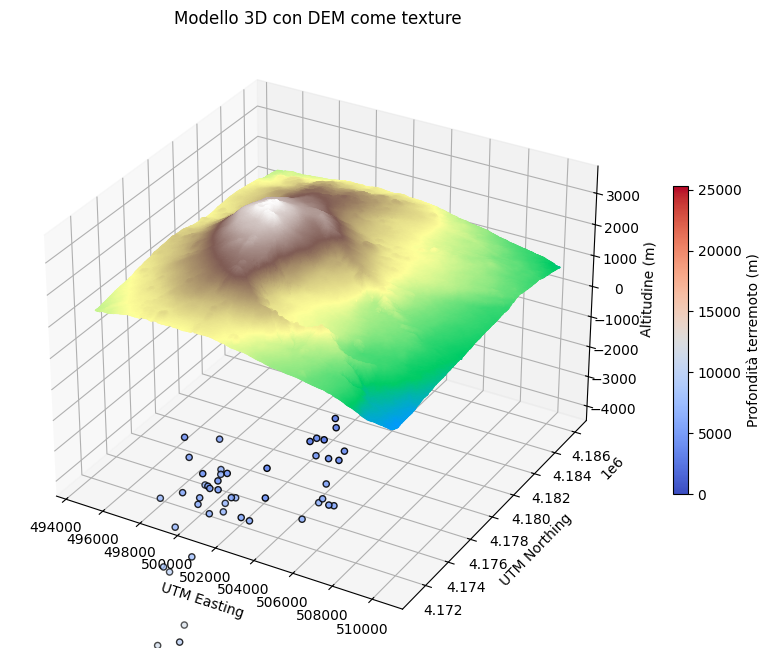

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---- 1️⃣ Carica il DEM come immagine ----
dem_path = "/content/drive/MyDrive/dati/dem_2015_4m.tiff"

with rasterio.open(dem_path) as dem:
    elevation = dem.read(1)  # Altitudine
    transform = dem.transform  # Matrice di trasformazione
    bounds = dem.bounds  # Limiti
    img_dem = dem.read(1)  # Carica i valori come immagine

# ---- 2️⃣ Crea la griglia UTM corrispondente ----
x_range = np.linspace(bounds.left, bounds.right, dem.width)
y_range = np.linspace(bounds.top, bounds.bottom, dem.height)
X_utm, Y_utm = np.meshgrid(x_range, y_range)

# ---- 3️⃣ Creazione della figura 3D ----
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# ---- 4️⃣ Mappa il DEM come texture ----
ax.plot_surface(X_utm, Y_utm, elevation, rstride=1, cstride=1, facecolors=plt.cm.terrain(img_dem / np.max(img_dem)), shade=False)

# ---- 5️⃣ Aggiungi i terremoti sotto il DEM ----
sc = ax.scatter(quake_x_utm, quake_y_utm, -quake_depth, c=quake_depth, cmap="coolwarm", edgecolors="black")

# ---- 6️⃣ Personalizza il grafico ----
ax.set_xlabel("UTM Easting")
ax.set_ylabel("UTM Northing")
ax.set_zlabel("Altitudine (m)")
ax.set_title("Modello 3D con DEM come texture")
ax.set_zlim(np.min(elevation) - 5000, np.max(elevation) + 500)

# Barra colore per profondità terremoti
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label("Profondità terremoto (m)")

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import pyproj
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D

# ---- 1. Carica il DEM e lo converte in coordinate UTM ----
dem_path = "/content/drive/MyDrive/dati/dem_2015_4m.tiff"  # Modifica con il percorso del tuo DEM
with rasterio.open(dem_path) as dem:
    dem_data = dem.read(1)  # Legge il primo layer (elevazione)
    bounds = dem.bounds  # Ottiene i limiti del DEM
    res_x, res_y = dem.res  # Risoluzione delle celle
    x_range = np.arange(bounds.left, bounds.right, res_x)
    y_range = np.arange(bounds.bottom, bounds.top, res_y)
    X, Y = np.meshgrid(x_range, y_range)

# ---- 2. Crea l'interpolatore per il DEM ----
interp_dem = RegularGridInterpolator((y_range, x_range), dem_data, bounds_error=False, fill_value=np.nan)

# ---- 3. Carica i dati dei terremoti ----
quake_path = "/content/drive/MyDrive/dati/terremoti2.csv"  # Modifica con il percorso del file CSV
earthquake_data = pd.read_csv(quake_path, sep=';')

# Converte le coordinate
quake_lat = earthquake_data["Latitude"].values
quake_lon = earthquake_data["Longitude"].values
quake_depth = earthquake_data["Depth/Km"].values * 1000  # Converti in metri

# ---- 4. Converti coordinate geografiche in UTM ----
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:32633")  # UTM zona 33N per l'Etna
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

# Converti DEM e terremoti in coordinate UTM
X_utm, Y_utm = transformer.transform(X.flatten(), Y.flatten())
quake_x_utm, quake_y_utm = transformer.transform(quake_lon, quake_lat)

# ---- 5. Filtra i punti validi dentro i limiti del DEM ----
valid_points = (quake_x_utm >= x_range.min()) & (quake_x_utm <= x_range.max()) & \
               (quake_y_utm >= y_range.min()) & (quake_y_utm <= y_range.max())

quake_x_valid = quake_x_utm[valid_points]
quake_y_valid = quake_y_utm[valid_points]
quake_depth_valid = quake_depth[valid_points]

# ---- 6. Interpolazione quota DEM per i terremoti validi ----
quake_surface_altitude = interp_dem((quake_y_valid, quake_x_valid))
quake_altitude = quake_surface_altitude - quake_depth_valid  # Profondità sotto la superficie

%matplotlib notebook

# ---- 7. Visualizzazione 3D ----
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotta la superficie del DEM
ax.plot_surface(X, Y, dem_data, cmap="terrain", edgecolor="none", alpha=0.6)

# Plotta i terremoti
sc = ax.scatter(quake_x_valid, quake_y_valid, quake_altitude, c=quake_depth_valid, cmap="coolwarm", edgecolors="black")

# Colorbar per la profondità
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Profondità terremoto (m)")

# Etichette
ax.set_xlabel("UTM Easting")
ax.set_ylabel("UTM Northing")
ax.set_zlabel("Altitudine (m)")
ax.set_title("Modello 3D DEM e ipocentri terremoti")

# Mostra il grafico
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
quake_path = "/content/drive/MyDrive/dati/terremoti.csv"
earthquake_data = pd.read_csv(quake_path, sep=';')
print(earthquake_data.head())

   #EventID                        Time  Latitude  Longitude  Depth/Km  \
0  17964011  2018-01-01T12:12:47.750000  377207.0   150083.0      11.0   
1  17980581  2018-01-04T15:08:48.070000  378018.0   150307.0      34.1   
2  17985081  2018-01-05T09:43:09.000000  377448.0   149655.0       9.3   
3  17989401  2018-01-06T03:29:29.790000  377445.0   150995.0      10.4   
4  18008251  2018-01-09T00:51:21.620000  377547.0   149348.0      26.4   

   Magnitude MagAuthor            EventLocationName  
0        1.8        --  9 km W Zafferana Etnea (CT)  
1        2.3        --    11 km W Linguaglossa (CT)  
2        1.9        --          13 km E Bronte (CT)  
3        1.6        --            3 km NW Milo (CT)  
4        1.6        --          10 km E Bronte (CT)  


In [ ]:
import numpy as np
import pandas as pd
import rasterio
import pyproj
import plotly.graph_objects as go

# ---- 1. Carica il DEM e lo converte in coordinate UTM ----
dem_path = "/content/drive/MyDrive/dati/dem_2015_4m.tiff"
with rasterio.open(dem_path) as dem:
    dem_data = dem.read(1)  # Legge il primo layer (elevazione)
    bounds = dem.bounds
    res_x, res_y = dem.res
    x_range = np.arange(bounds.left, bounds.right, res_x)
    y_range = np.arange(bounds.bottom, bounds.top, res_y)
    X, Y = np.meshgrid(x_range, y_range)

# ---- 2. Carica i dati dei terremoti ----
quake_path = "/content/drive/MyDrive/dati/terremoti.csv"
earthquake_data = pd.read_csv(quake_path, sep=';')

quake_lat = earthquake_data["Latitude"].values / 10000
quake_lon = earthquake_data["Longitude"].values / 10000
quake_depth = earthquake_data["Depth/Km"].values * 1000  # Converti in metri

# ---- 3. Converti coordinate geografiche in UTM ----
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:32633")  # UTM zona 33N (Etna)
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

# Converti DEM e terremoti in coordinate UTM
quake_x_utm, quake_y_utm = transformer.transform(quake_lon, quake_lat)

# ---- 4. Filtra i punti validi dentro i limiti del DEM ----
valid_points = (quake_x_utm >= x_range.min()) & (quake_x_utm <= x_range.max()) & \
               (quake_y_utm >= y_range.min()) & (quake_y_utm <= y_range.max())

quake_x_valid = quake_x_utm[valid_points]
quake_y_valid = quake_y_utm[valid_points]
quake_depth_valid = quake_depth[valid_points]

# ---- 5. Visualizzazione interattiva con Plotly ----
# Crea la superficie del DEM
dem_surface = go.Surface(z=dem_data, x=X, y=Y, colorscale="viridis", opacity=0.7)

# Crea i punti degli ipocentri
earthquake_points = go.Scatter3d(
    x=quake_x_valid,
    y=quake_y_valid,
    z=-quake_depth_valid,  # Plotly usa z verso l'alto, quindi mettiamo le profondità in negativo
    mode="markers",
    marker=dict(size=5, color=quake_depth_valid, colorscale="Jet", opacity=0.8),
    name="Ipocentri terremoti"
)

# Layout del grafico
layout = go.Layout(
    title="Etna, 2018 earthquakes location",
    scene=dict(
        xaxis_title="UTM Easting",
        yaxis_title="UTM Northing",
        zaxis_title="Altitudine (m)",
        aspectmode="auto"  # Mantiene le proporzioni corrette
    )
)

# Combina tutto nel grafico
fig = go.Figure(data=[dem_surface, earthquake_points], layout=layout)

# Mostra il grafico interattivo
fig.show()

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import pyproj
import plotly.graph_objects as go
import requests
from io import StringIO
from datetime import datetime

# ---- 1. Funzione per scaricare dati dall'API ----
def get_earthquake_data(starttime, endtime):
    api_url = f"https://webservices.ingv.it/fdsnws/event/1/query?starttime={starttime}&endtime={endtime}&minmag=0.3&maxmag=10&mindepth=-10&maxdepth=1000&minversion=100&orderby=time-asc&lat=37.751&lon=14.9903&maxradiuskm=5&format=text&limit=10000"

    response = requests.get(api_url)

    if response.status_code != 200:
        raise Exception("Errore nel recupero dati dall'API")

    # Converti la risposta testuale in un DataFrame
    data = pd.read_csv(StringIO(response.text), sep='|')

    # Seleziona le colonne necessarie
    data = data[['Latitude', 'Longitude', 'Depth/Km']].dropna()

    # Converti la profondità in metri
    data["Depth/m"] = data["Depth/Km"] * 1000

    return data

# ---- 2. L'utente inserisce le date ----
starttime_input = input("Inserisci data di inizio (YYYY-MM-DD HH:MM:SS): ")
endtime_input = input("Inserisci data di fine (YYYY-MM-DD HH:MM:SS): ")

# Converti le date nel formato richiesto dall'API (YYYY-MM-DDTHH:MM:SS)
starttime = datetime.strptime(starttime_input, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S")
endtime = datetime.strptime(endtime_input, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S")

# ---- 3. Scarica i dati dei terremoti ----
earthquake_data = get_earthquake_data(starttime, endtime)
print(earthquake_data)

# ---- 4. Carica il DEM e lo converte in coordinate UTM ----
dem_path = "/content/drive/MyDrive/dati/dem_2015_4m.tiff"
with rasterio.open(dem_path) as dem:
    dem_data = dem.read(1)
    bounds = dem.bounds
    res_x, res_y = dem.res
    x_range = np.arange(bounds.left, bounds.right, res_x)
    y_range = np.arange(bounds.bottom, bounds.top, res_y)
    X, Y = np.meshgrid(x_range, y_range)

# ---- 5. Converti coordinate geografiche in UTM ----
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:32633")  # UTM zona 33N (Etna)
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

# Converti terremoti in coordinate UTM
quake_x_utm, quake_y_utm = transformer.transform(earthquake_data["Longitude"].values, earthquake_data["Latitude"].values)

# ---- 6. Visualizzazione interattiva con Plotly ----
# Crea la superficie del DEM
dem_surface = go.Surface(z=dem_data, x=X, y=Y, colorscale="viridis", opacity=0.7)

# Crea i punti degli ipocentri
earthquake_points = go.Scatter3d(
    x=quake_x_utm,
    y=quake_y_utm,
    z=-earthquake_data["Depth/m"],  # Plotly usa z verso l'alto, quindi profondità in negativo
    mode="markers",
    marker=dict(size=5, color=earthquake_data["Depth/m"], colorscale="Jet", opacity=0.8),
    name="Ipocentri terremoti"
)

# Layout del grafico
layout = go.Layout(
    title=f"Modello 3D DEM e Ipocentri Terremoti Etna dal {starttime} al {endtime}",
    scene=dict(
        xaxis_title="UTM Easting",
        yaxis_title="UTM Northing",
        zaxis_title="Altitudine (m)",
        aspectmode="auto"
    )
)

# Combina tutto nel grafico
fig = go.Figure(data=[dem_surface, earthquake_points], layout=layout)

# Mostra il grafico interattivo
fig.show()


Inserisci data di inizio (YYYY-MM-DD HH:MM:SS): 2023-01-01 00:00:00
Inserisci data di fine (YYYY-MM-DD HH:MM:SS): 2025-01-01 00:00:00
     Latitude  Longitude  Depth/Km  Depth/m
0     37.7395    14.9997       6.7   6700.0
1     37.7780    14.9760       1.0   1000.0
2     37.7332    14.9658      10.5  10500.0
3     37.7537    15.0110       3.5   3500.0
4     37.7563    15.0043       2.7   2700.0
..        ...        ...       ...      ...
123   37.7190    15.0190       4.6   4600.0
124   37.7350    15.0420       2.9   2900.0
125   37.7480    15.0380       5.7   5700.0
126   37.7360    15.0250      12.1  12100.0
127   37.7240    14.9860       5.1   5100.0

[128 rows x 4 columns]
